In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False)
vgg.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [2]:
import glob
# 跟之前不同: 我只先把路徑寫好, 當我真正要的時候才去讀
import pandas as pd
train_df = pd.DataFrame(columns=["path", "target"])
for fn in glob.glob("train/cat.*.jpg"):
    s = pd.Series([fn, 0], index=["path", "target"])
    train_df = train_df.append(s, ignore_index=True)
for fn in glob.glob("train/dog.*.jpg"):
    s = pd.Series([fn, 1], index=["path", "target"])
    train_df = train_df.append(s, ignore_index=True)
train_df

,path,target
0,train/cat.0.jpg,0
1,train/cat.1.jpg,0
2,train/cat.10.jpg,0
3,train/cat.100.jpg,0
4,train/cat.1000.jpg,0
5,train/cat.10000.jpg,0
6,train/cat.10001.jpg,0
7,train/cat.10002.jpg,0
8,train/cat.10003.jpg,0
9,train/cat.10004.jpg,0


目標: 0
維度: (249, 250)


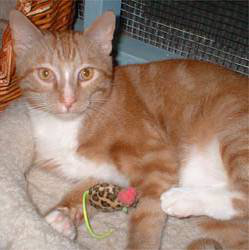

In [3]:
# 先印出圖片看一下
import matplotlib.pyplot as plt
%matplotlib inline
import random
from keras.preprocessing.image import load_img

c = random.randint(0, 24999)
imgname = train_df.iloc[c]["path"]
target = train_df.iloc[c]["target"]
img = load_img(imgname)
print("目標:", target)
print("維度:", img.size)
img

目標: 0
維度: (224, 224)


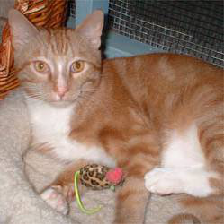

In [4]:
img = load_img(imgname, target_size=(224, 224))
print("目標:", target)
print("維度:", img.size)
img

In [18]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, BatchNormalization
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
# 只訓練腦袋, 不訓練眼睛, trainable=False
for l in vgg.layers:
    l.trainable = False
x = vgg.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
# 這裡有兩個選擇: units=1, activation="sigmoid"
# units=2, activation="softmax"
x = Dense(units=2, activation="softmax")(x)
model = Model(inputs = vgg.input, outputs = x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [19]:
vgg.layers

In [20]:
# 預處理: 跟之前不一樣的地方: 圖還沒載先不處理, 只處理目標的部分
# 先把target都變成one-hot
from keras.utils import np_utils
# 先把一部分的x保留下來做測試
from sklearn.model_selection import train_test_split
import numpy as np
# 養成這好習慣 丟到最後keras要處理的時候 請把df -> numpy 陣列(避免索引的問題還有跟keras配合)
x_train, x_test, y_train, y_test = train_test_split(np.array(train_df["path"]), 
                                                    np.array(train_df["target"]), 
                                                    test_size=0.1)
y_train_cat = np_utils.to_categorical(y_train)
y_train_cat

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [21]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
from keras.applications.vgg16 import preprocess_input
train_times = 5
batch_size = 20
for i in range(train_times):
    # 在numpy, randint第二個參數是不包括的
    c = np.random.randint(0, x_train.shape[0], batch_size)
    fs = x_train[c]
    # 準備一個載滿圖片的列表
    targets = y_train_cat[c]
    imglist = []
    for f in fs:
        img = load_img(f, target_size=(224, 224))
        img = preprocess_input(np.array(img))
        imglist.append(img)
    # 最後一件事: keras只吃numpy.array, 做完轉化再丟進去
    imglist = np.array(imglist)
    # 訓練訓練
    result = model.train_on_batch(imglist, targets)
    print(i, ":", result)

0 : [1.6118095, 0.9]
1 : [3.5164902, 0.75]
2 : [1.6169456, 0.9]
3 : [3.028956, 0.8]
4 : [2.024981, 0.8]


In [28]:
y_test_cat = np_utils.to_categorical(y_test)
# 在numpy, randint第二個參數是不包括的
c = np.random.randint(0, x_test.shape[0], 50)
fs = x_test[c]
# 準備一個載滿圖片的列表
targets = y_test_cat[c]
imglist = []
oriimglist = []
for f in fs:
    oriimg = load_img(f, target_size=(224, 224))
    oriimglist.append(oriimg)
    img = preprocess_input(np.array(oriimg))
    imglist.append(img)
# 最後一件事: keras只吃numpy.array, 做完轉化再丟進去
imglist = np.array(imglist)
model.evaluate(imglist, targets)

50/50 [==============================] - 18s 360ms/step


[1.7069385385513305, 0.8800000023841857]

In [31]:
pre = model.predict(imglist).argmax(axis=-1)
pre

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0])

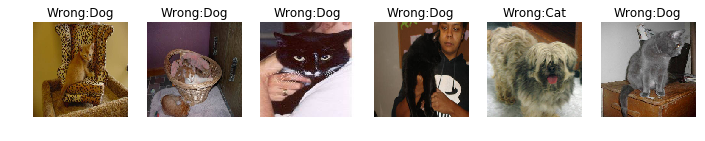

In [40]:
# 參考我做, 語法比較難
ans = y_test[c]
# 預測錯的答案 正確答案 那個圖片
wrong = []
right = []
wrongimg = []
trans = {0:"Cat", 1:"Dog"}
for (index, p) in enumerate(pre):
    if not p == ans[index]:
        wrong.append(p)
        right.append(ans[index])
        wrongimg.append(oriimglist[index])
# subplot(總列數, 總行數, 幾幅圖)
plt.figure(figsize=(20, 10))
columns = 10
rows = int(len(wrongimg) / columns) + 1
for (index, i) in enumerate(wrongimg):
    plt.subplot(rows, columns, index + 1)
    plt.title("Wrong:" + trans[wrong[index]])
    plt.axis("off")
    plt.imshow(i)